In [1]:
import numpy as np
import pandas as pd
import nltk
import re
import os
import codecs
from sklearn import feature_extraction
#import mpld3

In [2]:
text_df = pd.read_csv("output/troll_detection/authors_citations/ok/textblob.csv")
text_df = text_df.reindex(columns=['authid','text'])
text_df.head(3)

,authid,text
0,16309395600,Oil spill detection system - Results from fiel...
1,16310768700,Oil spill detection system - Results from fiel...
2,23024335400,Propagation of trust and distrust for the dete...


In [3]:
stopwords = nltk.corpus.stopwords.words('english')

In [4]:
# load nltk's SnowballStemmer as variabled 'stemmer'
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

In [5]:
# here I define a tokenizer and stemmer which returns the set of stems in the text that it is passed

def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [6]:
#not super pythonic, no, not at all.
#use extend so it's a big flat list of vocab
totalvocab_stemmed = []
totalvocab_tokenized = []
for row in text_df.itertuples():
    i=row[-1]
    allwords_stemmed = tokenize_and_stem(i) #for each item in 'synopses', tokenize/stem
    totalvocab_stemmed.extend(allwords_stemmed) #extend the 'totalvocab_stemmed' list

    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

In [7]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
print ('there are ' + str(vocab_frame.shape[0]) + ' items in vocab_frame')

there are 14127 items in vocab_frame


In [8]:
vocab_frame = vocab_frame.drop_duplicates()
vocab_frame.describe()
#vocab_frame.head(10)

,words
count,1258
unique,1258
top,tromsø
freq,1


In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer( max_features=20000,max_df=0.95,
                                 min_df=0.05, stop_words=stopwords,
                                 use_idf=True, tokenizer=tokenize_and_stem,
                                    ngram_range=(1,1))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(text_df['text']) #fit the vectorizer to synopses
print('tfidf_matrix has (rows(authors), cols(keywords)):')
print(tfidf_matrix.shape)

CPU times: user 426 ms, sys: 3.19 ms, total: 429 ms
Wall time: 431 ms
tfidf_matrix has (rows(authors), cols(keywords)):
(48, 632)


In [10]:
terms = tfidf_vectorizer.get_feature_names()
len(tfidf_vectorizer.get_feature_names())

632

In [11]:
' ,'.join(terms[:100])

"'s ,2014.the ,abil ,abstract ,access ,accident ,accompani ,account ,accur ,accuraci ,achiev ,acm.sign ,acoust ,act ,action ,activ ,actual ,adapt ,administr ,advantag ,aerial ,affect ,agenc ,aggreg ,ai ,aim ,al ,algorithm ,allow ,almost ,along ,also ,alter-ego ,amount ,analys ,analysi ,analyt ,analyz ,ani ,annular ,anomal ,anomali ,anonym ,antarctica ,apertur ,appeal ,appear ,appli ,applic ,approach ,approxim ,argument ,articl ,assist ,associ ,atmospher ,attack ,author ,autom ,automat ,avail ,awar ,b.v. ,back ,backpressur ,base ,baselin ,basi ,becaus ,becom ,befor ,behavior ,behaviour ,benefit ,benign ,bias ,binari ,boat ,bot ,bottom-hol ,bring ,bypass ,call ,capabl ,carri ,case ,categoris ,caus ,certifi ,challeng ,characterist ,choke ,christma ,circul ,classif ,classifi ,clean ,clear ,close ,cluster"

In [13]:
from sklearn.metrics.pairwise import cosine_similarity
cosdist = 1 - cosine_similarity(tfidf_matrix)
cosdist=np.round(cosdist,2)

In [14]:
from sklearn.cluster import KMeans

num_clusters = 5

km = KMeans(n_clusters=num_clusters,verbose=0,max_iter=80,n_init=3)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

CPU times: user 51.3 ms, sys: 818 µs, total: 52.1 ms
Wall time: 53 ms


In [15]:
output = { 'authid': list(text_df['authid']), 'cluster': clusters, 'text': list(text_df['text']) }

frame = pd.DataFrame(output, index = [clusters] , columns = ['authid', 'cluster', 'text'])

In [19]:
km.cluster_centers_.argsort()[:, ::-1] 



array([[244, 124, 167, ..., 405, 406, 315],
       [509,  35, 237, ..., 403, 402,   0],
       [367, 531, 601, ..., 352, 353,   0],
       [385, 503, 510, ..., 337, 548, 631],
       [158, 347,  35, ..., 412, 413, 315]])

In [21]:
print("Top terms per cluster:")
print()
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 
cluster_names = {}

for i in range(num_clusters):
    print("Cluster {} words:".format(i))
    st = ''
    for ind in order_centroids[i, :10]: #replace 10 with n words per cluster
        st += "{}, ".format(vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0])
    print(st[0:-2]) #drop last comma
    cluster_names[i]=st[0:-2]
    print("Cluster {} has ".format(i), end='')
    print('{} authors.'.format(len(frame.ix[i]['authid'].values.tolist())))
    print() #add whitespace
    print() #add whitespace


Top terms per cluster:

Cluster 0 words:
gas, control, drilling, system, well, installation, dual, riser, gradient, tested
Cluster 0 has 8 authors.


Cluster 1 words:
sentiment, analysis, forums, ordinal, binary, data, troll, classification, settings, training
Cluster 1 has 5 authors.


Cluster 2 words:
network, social, users, trust, real, ranking, 'signed, generation, troll, methods
Cluster 2 has 23 authors.


Cluster 3 words:
oil, satellite, services, vessels, spill, ksat, pollution, trials, operation, identification
Cluster 3 has 7 authors.


Cluster 4 words:
discussion, media, analysis, bots, fakeholders, sentiment, social, troll, cyborgs, tools
Cluster 4 has 5 authors.




In [25]:
print(cluster_names)

{0: 'gas, control, drilling, system, well, installation, dual, riser, gradient, tested', 1: 'sentiment, analysis, forums, ordinal, binary, data, troll, classification, settings, training', 2: "network, social, users, trust, real, ranking, 'signed, generation, troll, methods", 3: 'oil, satellite, services, vessels, spill, ksat, pollution, trials, operation, identification', 4: 'discussion, media, analysis, bots, fakeholders, sentiment, social, troll, cyborgs, tools'}


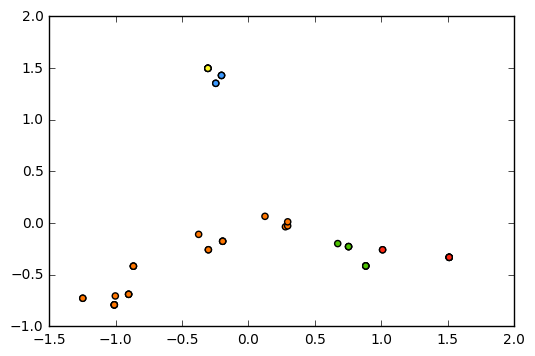

2D cosine distance matrix projection


In [33]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


pca = PCA(n_components=2).fit(cosdist)
data2D = pca.transform(cosdist)
#colormap = np.array(['red', 'lime', 'black', 'blue','purple','cyan','orange','pink'])
colormap = np.array(['#4DC200', '#FFF926', '#FF7600', '#FF2813', '#3B99FF'])

plt.scatter(data2D[:,0], data2D[:,1], c=colormap[km.labels_])
plt.show() 
print('2D cosine distance matrix projection')

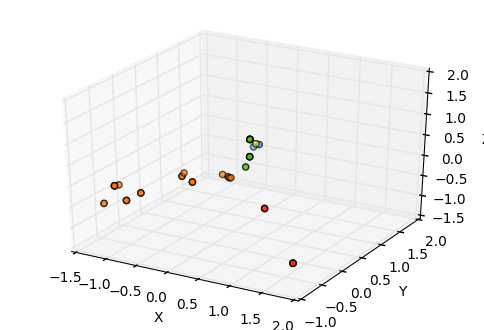

3D cosine distance matrix projection


In [35]:
from mpl_toolkits.mplot3d import Axes3D


pca = PCA(n_components=3).fit(cosdist)
data3D = pca.transform(cosdist)


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


ax.scatter(data3D[:,0], data3D[:,1],data3D[:,2], c=colormap[km.labels_])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show() 
print('3D cosine distance matrix projection')

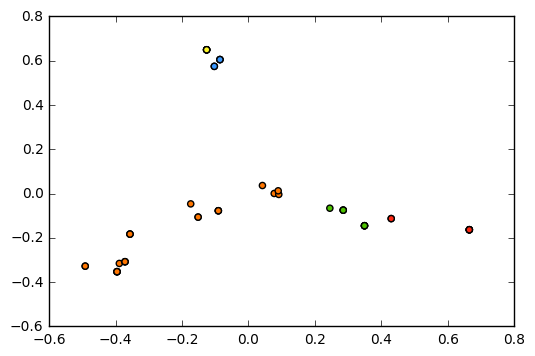

2D tf-idf vectors matrix projection


In [36]:
pca = PCA(n_components=2).fit(tfidf_matrix.toarray())
data2D = pca.transform(tfidf_matrix.toarray())
#colormap = np.array(['red', 'lime', 'black', 'blue','purple','cyan','orange','pink'])

plt.scatter(data2D[:,0], data2D[:,1], c=colormap[km.labels_])

plt.show() 
print('2D tf-idf vectors matrix projection')

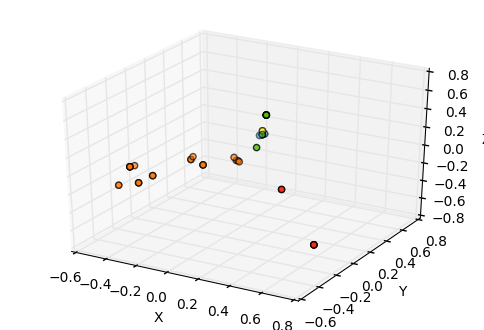

3D tf-idf vectors matrix projection


In [37]:
pca = PCA(n_components=3).fit(tfidf_matrix.toarray())
#data3D = pca.transform(frame[['authid','cluster']])
data3D = pca.transform(tfidf_matrix.toarray())

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


ax.scatter(data3D[:,0], data3D[:,1],data3D[:,2], c=colormap[km.labels_])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show() 
print('3D tf-idf vectors matrix projection')

In [40]:
#TruncatedSVD and t-SNE on cosdist matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

X_reduced = TruncatedSVD(n_components=20, random_state=0).fit_transform(cosdist)
X_cosdist = TSNE(n_components=2, perplexity=40, verbose=1).fit_transform(X_reduced)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 47 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 48 / 48
[t-SNE] Mean sigma: 2.121211
[t-SNE] KL divergence after 100 iterations with early exaggeration: 0.978257
[t-SNE] Error after 125 iterations: 0.978257


In [41]:
#TruncatedSVD and t-SNE on tfidf_matrix

X_reduced = TruncatedSVD(n_components=50, random_state=0).fit_transform(tfidf_matrix)
X_tfidf = TSNE(n_components=2, perplexity=40, verbose=1).fit_transform(X_reduced)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 47 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 48 / 48
[t-SNE] Mean sigma: 1.020330
[t-SNE] KL divergence after 75 iterations with early exaggeration: 0.783855
[t-SNE] Error after 100 iterations: 0.783855


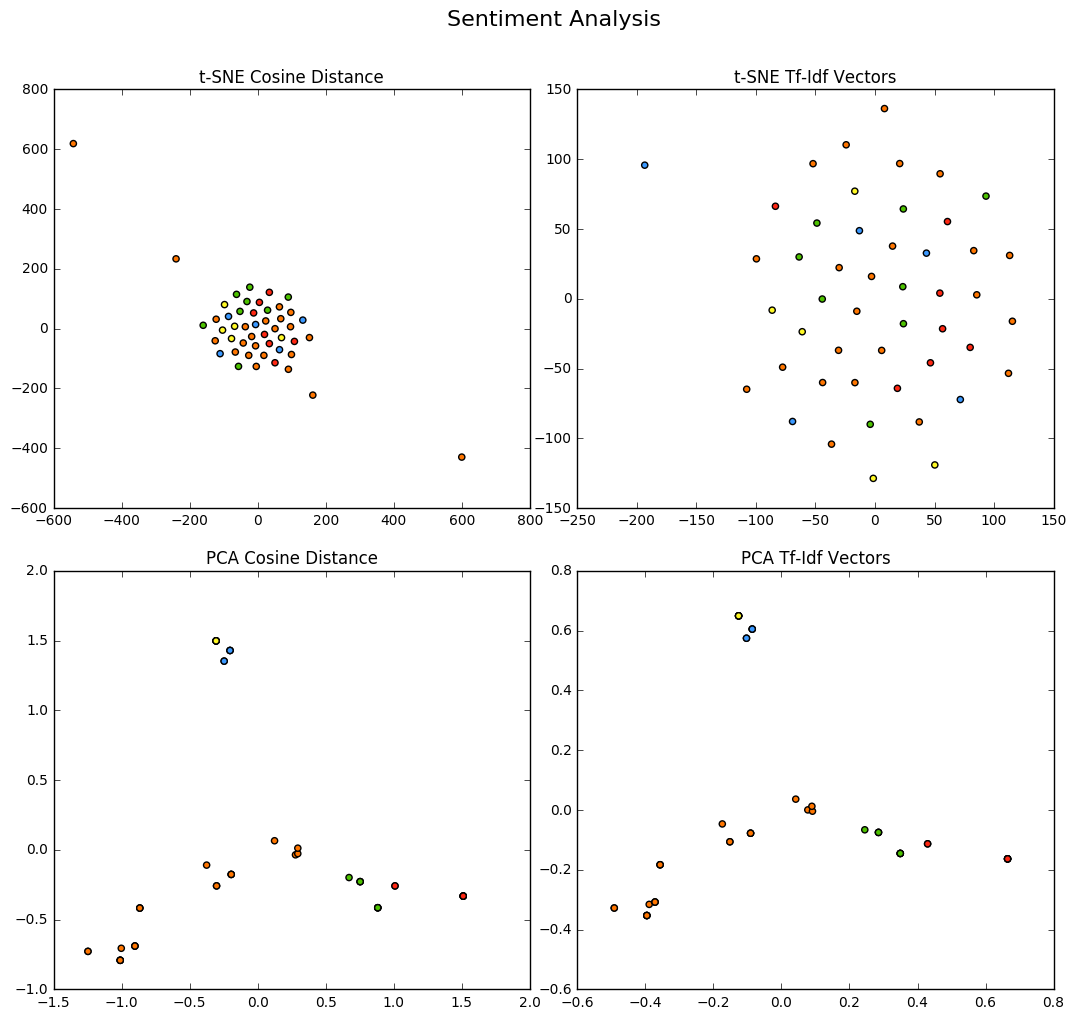

In [42]:
from sklearn.decomposition import PCA


pca_tfidf = PCA(n_components=2).fit_transform(tfidf_matrix.toarray())
pca_cosdist = PCA(n_components=2).fit_transform(cosdist)

import matplotlib.pyplot as plt
colormap = np.array(['#4DC200', '#FFF926', '#FF7600', '#FF2813', '#3B99FF'])

#2d plot

fig = plt.figure(figsize=(10, 10))
# plot setup
fig.suptitle("Sentiment Analysis", fontsize=16)
ax = plt.axes(frameon=False)
plt.setp(ax, xticks=(), yticks=())
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=0.9, wspace=0.1, hspace=0.15)
# 1st plot
ax = plt.subplot("221")
ax.set_title("t-SNE Cosine Distance")
ax.scatter(X_cosdist[:, 0], X_cosdist[:, 1],
        c=colormap[km.labels_], marker="o")
# 2nd plot
ax = plt.subplot("222")
ax.set_title("t-SNE Tf-Idf Vectors")
ax.scatter(X_tfidf[:, 0], X_tfidf[:, 1],
        c=colormap[km.labels_], marker="o")
# 3rd plot
ax = plt.subplot("223")
ax.set_title("PCA Cosine Distance")
ax.scatter(pca_cosdist[:,0], pca_cosdist[:,1], c=colormap[km.labels_])

# 4th plot
ax = plt.subplot("224")
ax.set_title("PCA Tf-Idf Vectors")
ax.scatter(pca_tfidf[:,0], pca_tfidf[:,1], c=colormap[km.labels_], marker="o")